In [224]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [441]:
class Atribute:
    name: str
    mode = None
    values: list
    next: dict = dict()

    def __init__(self, name, mode=None, values=None):
        self.name = name
        self.values = values
        self.mode = mode

    def add_next(self, value: str, next_atribute: Atribute):
        self.next[value] = next_atribute

    def get_next(self, value: str):
        if value not in self.next.keys():
            return None
        return self.next[value]

    def set_mode(self, mode: str):
        self.mode = mode

    def get_name(self):
        return self.name

    def get_mode(self):
        return self.mode

    def get_values(self):
        return self.values

class DecisionTree:
    labels: list
    n_labels: int
    root: Atribute
    features: list
    confusion_matrix: np.array

    def __init__(self):
        self.features = []
        self.labels = []
        self.root = None

    def information_gain(self, s: pd.DataFrame, atribute: str):
        values = s[atribute].unique()
        sum = 0
        for value in values:
            sv = s[s[atribute]==value]
            pv = len(sv) / len(s)
            ev = self.entropy(sv)
            sum = sum + pv*ev
        return self.entropy(s) - sum

    def entropy(self, s: pd.DataFrame):
        if len(s) == 0:
            return 0

        labels = s.target.unique()
        n_labels = s.target.nunique()
        proba = []

        for label in labels:
            proba.append(len(s[s.target == label]) / len(s))

        if 0 in proba:
            return 0
        else:
            entropy = 0
            for p in proba:
                entropy -= p*math.log(p, self.n_labels)

        return entropy

    def train_model(self, samples: pd.DataFrame, prev: Atribute, value: str):
        if samples.target.empty:
            if prev == None:
                return

            node = Atribute(name=prev.get_mode())
            node.add_next('class', None)

            prev.add_next(value, node)
            return

        if len(self.features) == 0 or samples.target.nunique() == 1:
            classification = samples.target.mode().loc[0]
            node = Atribute(name=classification)
            node.add_next('class', None)

            prev.add_next(value, node)

            return

        most_relevant = ['', -1]
        for atribute in self.features:
            name = atribute.get_name()
            gain = self.information_gain(samples, name)
            if gain > most_relevant[1]:
                most_relevant = [atribute, gain]

        atribute, _ = most_relevant
        atribute_mode = samples.target.mode().loc[0]

        node = Atribute(atribute.get_name(), mode=atribute_mode, values=atribute.get_values())

        self.features.remove(atribute)

        if prev != None:
            prev.add_next(value, node)
        else:
            self.root = node

        for value in node.get_values():
            subset = samples[samples[atribute.get_name()] == value]
            self.train_model(subset, node, value)

    def fit(self, train_samples: pd.DataFrame):
        self.labels = list(train_samples.target.unique())
        self.n_labels = len(self.labels)
        self.confusion_matrix = np.zeros((self.n_labels, self.n_labels))

        for feature in train_samples.drop(columns='target').columns.tolist():
            values = train_samples[feature].unique()
            self.features.append(Atribute(feature, None, values))

        self.train_model(train_samples, None, None)

    def predict(self, samples: pd.DataFrame):
        test_mode = samples.target.mode().loc[0]
        current_node = self.root
        predicted_label = ''
        for _, row in samples.iterrows():
            current_node = self.root
            while current_node != None:
                node_name = current_node.get_name()
                if node_name in self.labels:
                    predicted_label = node_name
                    break

                value = row[node_name]
                next_node = current_node.get_next(value)

                if next_node == None:
                    subset_mode = samples[samples[node_name] == value].target.mode().loc[0]
                    predicted_label = test_mode
                    break

                current_node = next_node

            self.update_matrix(str(predicted_label), str(row.target))

    def update_matrix(self, predicted_label: str, true_label: str):
        predicted_index = self.labels.index(predicted_label)
        true_index = self.labels.index(true_label)

        self.confusion_matrix[true_index][predicted_index] += 1

    def plot_confusion_matrix(self):
        cm = ConfusionMatrixDisplay(self.confusion_matrix, display_labels=self.labels)

        cm.plot()
        plt.show()

In [442]:
def format_df(df: pd.DataFrame):
    for column in df.select_dtypes(include='number'):
        df[column].fillna(df[column].mean(), inplace=True)

    for column in df.select_dtypes(include='object'):
        df[column].fillna(df[column].mode().loc[0], inplace=True)

    return df

def drop_unwanted(df: pd.DataFrame):
    df.drop_duplicates(inplace=True)
    df.drop(df[df['NCAP Rating'] == 'Not Rated'].index, inplace=True)
    df.drop(df[df['NCAP Rating'] == 'Not Tested'].index, inplace=True)
    df.drop(columns='Model', inplace=True)

    return df

def sturges_method(n: int):
    return math.ceil(1 + 3.32 * math.log10(n))

def convert_to_categorical(df: pd.DataFrame):
    len_df = df.shape[0]

    n_classes = sturges_method(len_df)
    multiplier = 1
    for column in df.select_dtypes(include='number'):
        max = df[column].max()
        min = df[column].min()
        amplitude = max - min

        multiplier = 1
        categorized_column = []

        interval = (amplitude / n_classes) + 0.05 # reduce imprecision

        ini = min
        for value in df[column].values:
            if value >= (min + (interval*multiplier)):
                ini += interval
                multiplier += 1

            categorized_column.append(str(np.round(ini, 1)) + ' -- ' + str(np.round(interval + ini, 1)))

        df.drop(columns=column, inplace=True)
        df.insert(1, column, categorized_column)

    return df

In [447]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Cars_India_Dataset.csv')

df = drop_unwanted(df)
df = format_df(df)

df.sort_values(by=df.columns.tolist(), inplace=True)
df = convert_to_categorical(df)

df.rename(columns={'NCAP Rating': 'target'}, inplace=True)

x_train, x_test = train_test_split(df, test_size=0.2)
df

,Maker,Variants,Fuel Efficiency,Boot Space,Fuel Tank Capacity,Turning Radius,No_of_Cylinders,Wheelbase,Height,Width,...,Type,Fuel,Engine Type,Transmission,Front Brake,Rear Brake,Drive,Emission Type,Tyre Size,target
39,Citroen,1 -- 3.4,11.1 -- 13.2,244.4 -- 298.8,34.6 -- 41.1,4.9 -- 5.1,3.2 -- 3.4,2501.8 -- 2581.6,1521.2 -- 1567.4,1644.0 -- 1709.1,...,SUV,Diesel,DW10FC,8 AT,Disc,Disc,2 WD,BS VI,235/55 R18,4
17,Honda,1 -- 3.4,13.2 -- 15.2,298.8 -- 353.3,34.6 -- 41.1,5.1 -- 5.3,3.4 -- 3.5,2501.8 -- 2581.6,1567.4 -- 1613.5,1709.1 -- 1774.2,...,Compact SUV,Petrol,SOHC i-VTEC,5 MT,Disc,Drum,2WD,BS VI,195/60 R16,4
18,Honda,1 -- 3.4,15.2 -- 17.3,353.3 -- 407.7,34.6 -- 41.1,5.1 -- 5.3,3.5 -- 3.7,2501.8 -- 2581.6,1567.4 -- 1613.5,1709.1 -- 1774.2,...,Compact SUV,Diesel,DOHC i-DTEC,6 MT,Disc,Drum,2WD,BS VI,195/60 R16,4
8,Honda,1 -- 3.4,17.3 -- 19.4,407.7 -- 462.1,34.6 -- 41.1,5.1 -- 5.3,3.7 -- 3.9,2501.8 -- 2581.6,1567.4 -- 1613.5,1709.1 -- 1774.2,...,Compact Sedan,Petrol,SOHC i-VTEC,5 MT,Disc,Drum,2WD,BS VI,175/65 R15,4
9,Honda,1 -- 3.4,17.3 -- 19.4,407.7 -- 462.1,34.6 -- 41.1,5.1 -- 5.3,3.9 -- 4.0,2501.8 -- 2581.6,1567.4 -- 1613.5,1709.1 -- 1774.2,...,Compact Sedan,Petrol,SOHC i-VTEC,CVT,Disc,Drum,2WD,BS VI,175/65 R15,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,Volkswagen,15.6 -- 18.0,23.5 -- 25.6,571.0 -- 625.4,73.8 -- 80.4,5.7 -- 5.9,3.9 -- 4.0,2980.6 -- 3060.4,1798.2 -- 1844.4,1969.3 -- 2034.3,...,Mid Size SUV,Petrol,1.0L TSI,6-Speed AT,Disc,Drum,2WD,BS VI,205/55 R17,5
3,Volkswagen,15.6 -- 18.0,23.5 -- 25.6,571.0 -- 625.4,73.8 -- 80.4,5.7 -- 5.9,3.9 -- 4.0,2980.6 -- 3060.4,1798.2 -- 1844.4,1969.3 -- 2034.3,...,Mid Size SUV,Petrol,1.0L TSI,6-Speed MT,Disc,Drum,2WD,BS VI,205/55 R17,5
5,Volkswagen,15.6 -- 18.0,23.5 -- 25.6,571.0 -- 625.4,73.8 -- 80.4,5.7 -- 5.9,3.9 -- 4.0,2980.6 -- 3060.4,1798.2 -- 1844.4,1969.3 -- 2034.3,...,Mid Size SUV,Petrol,1.5L TSI Evo with ACT,6-Speed MT,Disc,Drum,2WD,BS VI,205/55 R17,5
6,Volkswagen,15.6 -- 18.0,23.5 -- 25.6,571.0 -- 625.4,73.8 -- 80.4,5.7 -- 5.9,3.9 -- 4.0,2980.6 -- 3060.4,1798.2 -- 1844.4,1969.3 -- 2034.3,...,Mid Size SUV,Petrol,1.5L TSI Evo with ACT,7-Speed DSG,Disc,Drum,2WD,BS VI,205/55 R17,5


In [448]:
dct = DecisionTree()

dct.fit(x_train)

In [449]:
dct.predict(x_test)

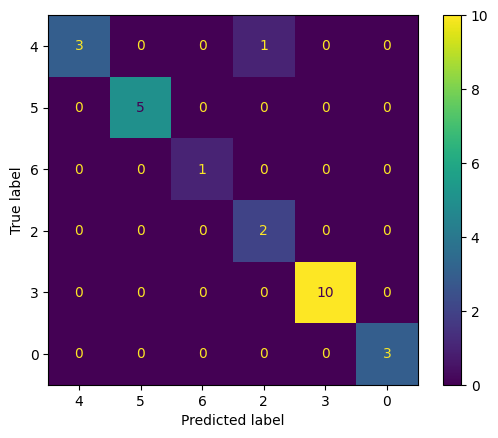

In [450]:
dct.plot_confusion_matrix()